# Project 1: Regression and Model Selection

In this project, you will construct a (linear) regression model, and apply it to a synthetic task as well as a real-world house value prediction task.

## Objectives
Your goal in this project is to get comfortable in implementing a complete supervised learning pipeline (in Python). To complete this project, you should understand the following:

* How to use basic math and machine learning modules in python such as numpy, matplotlib, and sklearn
* How to train a regression model *from scratch*
* How to implement the *gradient descent* algorithm for iterative model update
* How to perform model section when facing multiple choices
* How to evaluate the test results and visualize the outcome of an ML model

## Deliverable
* Project report/writeup: A `project1_report_lastname.pdf` file with corresponding plots and results for the project. Follow the `Project 1 - Report (Individual Submission)` link on Gradescope to upload this file. The project report should include a brief justification of your solution at a high-level, e.g., using any relevant explanations, equations, or pictures that help to explain your solution. You should also describe what your code does, e.g. using a couple of sentences per function to describe your code structure. In particular, we recommend against submitting the pdf export of the Python notebook; however you are welcome to copy/take screenshots of your code in this notebook to aid your explanations.

* Source code: A `project1_src_lastname1[_lastname2].ipynb` (or `.zip`) file with a working copy of your solutions compiled in a Jupyter notebook. Follow the `Project 1 - Source Code (Group Submission)` link to upload this file.


## Logistics

* You can work in groups of 1-2 students for each course project, and it's your responsibility to find a group (e.g. use Ed Discussion). 
* Every member of a group must complete and submit the project report/writeup individually. While the source code can be the same for all group members, the project report needs to be written independently by each person and, thus, should differ among team member and students more generally.
* One group member need to submit the source code. If you submit as a group, make sure to include your teammate in the group submission. Instructions for team submission can be found [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
* Grades will be provided based on the individual project report. The source code submission will not be graded, but the teaching staff may check the source files if they see the need for reproducing your results when going through your project report. 
* Failure to submit the source code will lead to a deduction of points from your total.


# Task 1A: Linear Regression Implementation from Scratch (50 points + 10 bonus points)

## Preparation


### Overview
In this task, you will implement linear regression with gradient descent optimization from scratch. You'll work with a synthetic dataset to understand the core concepts of regression and optimization.

### Learning Objectives
- Implement linear regression without using pre-built ML libraries
- Understand gradient descent optimization
- Learn to visualize and analyze model performance
- Master loss function implementation and optimization

### Loading Necessary Dependencies

In [1]:
%matplotlib inline

# General math and plotting modules.
# NumPy is a library for numerical operations on large, multi-dimensional arrays and matrices.
import numpy as np                                      
# Matplotlib is a plotting library for creating static, animated, and interactive visualizations in Python.
import matplotlib.pyplot as plt

# train_test_split is a utility function to split data into training and testing sets.
from sklearn.model_selection import train_test_split
# StandardScaler is used to standardize features by removing the mean and scaling to unit variance.
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

### Utility Functions

This section provides utility functions for data generation and visualization. These functions are pre-implemented to help you focus on the core machine learning concepts. You don't need to modify these functions.

#### Data Generation

In [2]:
from typing import Tuple

def generate_polynomial_data(num_points: int, noise: float, w: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate synthetic polynomial regression data.
    
    Args:
        num_points (int): Number of data points to generate
        noise (float): Standard deviation of Gaussian noise
        w (np.ndarray): True polynomial coefficients [w_0, ..., w_n] where n is the polynomial degree, of shape (degree+1, )
    
    Returns:
        X (np.ndarray): Feature matrix of shape (num_points, degree+1). Each row is [1, x, x^2, ..., x^n]
        y (np.ndarray): Target values of shape (num_points, )
    """
    dim = w.size - 1  # Polynomial degree
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Generate base feature values from normal distribution
    x = np.random.normal(size=(num_points, 1))
    
    X = np.concatenate([np.power(x, d) for d in range(dim + 1)], axis = 1)
        
    # Generate target values: y = Xw + noise
    y = X @ w + np.random.normal(size=(num_points,)) * noise

    return X, y

#### Visualization Functions

In [3]:
def plot_data(X: np.ndarray, y: np.ndarray, fig=None, options: dict = dict())->None:
    """
    Plot data points.
    
    Args:
        X (np.array): Feature values for x-axis of shape (num_points, num_features)
        y (np.array): Values for y-axis (num_points,)
        fig: Matplotlib figure object (optional)
        options (dict): Plotting options including:
            - marker: Point style (default: 'b*')
            - label: Legend label (default: 'Raw data')
            - fillstyle: Point fill style (default: 'full')
            - size: Point size (default: 8)
    """
    if fig is None:
        fig = plt.subplot(111)
    
    # Plot data points with specified options
    fig.plot(X, y, 
            options.get('marker', 'b*'),
            label=options.get('label', 'Raw data'),
            fillstyle=options.get('fillstyle', 'full'),
            ms=options.get('size', 8))
    
    process_plot(fig, options)

def plot_fit(X: np.array, w: np.array, fig=None, options: dict = dict())->None:
    """
    Plot the polynomial regression fit line.
    
    Args:
        X (np.array): Original feature matrix of shape (num_points, num_features)
        w (np.array): Learned polynomial coefficients (num_features, )
        fig: Matplotlib figure object (optional)
        options (dict): Plotting options
    """
    if fig is None:
        fig = plt.subplot(111)

    # Get range of x values to plot
    x_min = np.min(X[:, 1])
    x_max = np.max(X[:, 1])
    dim = w.size - 1  # Polynomial degree
    
    # Generate smooth x values for plotting
    x_plot = np.linspace(x_min, x_max, 100).reshape(-1, 1)
    
    X_plot = np.concatenate([np.power(x_plot, d) for d in range(dim + 1)], axis = 1)

    y_plot = X_plot @ w
    
    # Plot regression line
    fig.plot(x_plot, y_plot, 'r-', 
            label=options.get('label', 'Regression fit'))
    
    process_plot(fig, options)

def process_plot(fig, options: dict = dict())->None:
    """
    Apply common plotting options to figure.
    
    Args:
        fig: Matplotlib figure object
        options (dict): Dictionary of plotting options including:
            - x_label: Label for x-axis
            - y_label: Label for y-axis
            - x_lim: Limits for x-axis
            - y_lim: Limits for y-axis
            - title: Plot title
            - legend: Whether to show legend
            - legend_loc: Legend location
    """
    # Set axis labels
    if 'x_label' in options.keys():
        fig.set_xlabel(options['x_label'])
    if 'y_label' in options.keys():
        fig.set_ylabel(options['y_label'])
    
    # Set axis limits
    if 'x_lim' in options.keys():
        fig.set_ylim(options['x_lim'])
    if 'y_lim' in options.keys():
        fig.set_ylim(options['y_lim'])
    
    # Set title and legend
    if 'title' in options.keys():
        fig.set_title(options['title'])
    if 'legend' in options.keys():
        if options['legend']:
            fig.legend(loc=options.get('legend_loc', 'best'))

### Usage Example
Notes:
- The `generate_polynomial_data` function creates synthetic data following $y = w_n x^n + w_{n-1} x^{n-1} + \dots + w_1 x + w_0 + \text{noise}$
- The plotting functions support customization through the options dictionary
- These functions are designed to work with polynomial regression of any degree

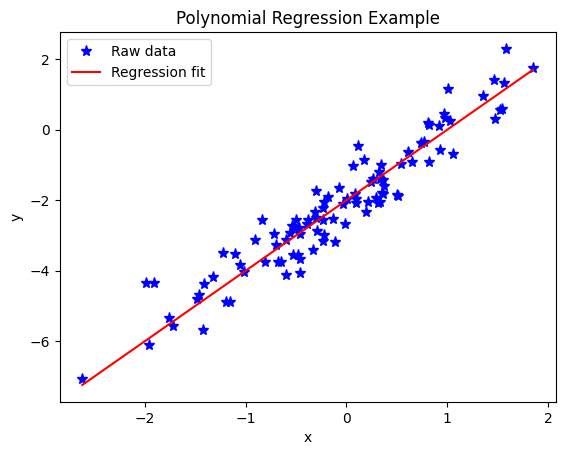

In [4]:
# Generate synthetic data
num_points_example = 100
noise_example = 0.6
w_true_example = np.array([-2, 2])  # Linear function: y = -2 + 2x
X_example, y_example = generate_polynomial_data(num_points_example, noise_example, w_true_example)

# Create plot
fig = plt.subplot(111)
plot_options = {
    'x_label': 'x',
    'y_label': 'y',
    'title': 'Polynomial Regression Example',
    'legend': True
}

# Plot data and fit
# The x-axis as used here is the 1st degree feature, i.e., x^1 = x
plot_data(X_example[:, 1], y_example, fig=fig, options=plot_options)
plot_fit(X_example, w_true_example, fig=fig, options=plot_options)
plt.show()

### Loading and Processing dataset 

Here, we're going to generate and process the dataset we'll use for the rest of the task.

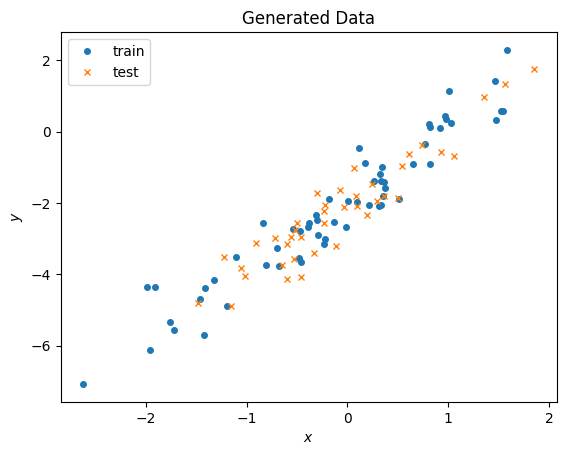

In [5]:
def generate_and_plot_data(num_points: int, noise: float, w_true: np.array, test_size: float = 0.4) -> Tuple[np.array, np.array, np.array, np.array]:
    """
    Generate synthetic polynomial regression data, split into training and testing sets, and plot the data.
    
    Args:
        num_points (int): Number of data points to generate
        noise (float): Standard deviation of Gaussian noise
        w_true (np.array): True polynomial coefficients [w_n, ..., w_1, w_0]
        test_size (float): Proportion of the dataset to include in the test split
    
    Returns:
        X_train (np.array): Training feature matrix of shape (num_train, num_features)
        X_test (np.array): Testing feature matrix of shape (num_test, num_features)
        y_train (np.array): Training target values of shape (num_train, )
        y_test (np.array): Testing target values of shpae (num_test, )
    """
    # Generate the data
    X, y = generate_polynomial_data(num_points, noise, w_true)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Plot Data
    fig = plt.subplot(111)
    fig.clear()  # Clear previous plot to avoid accumulation
    train_plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Generated Data', 'y_lim': [np.min(y) - 0.5, np.max(y) + 0.5], 'marker': 'o', 'size': 4, 'label': 'train'}
    test_plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Generated Data', 'y_lim': [np.min(y) - 0.5, np.max(y) + 0.5], 'marker': 'x', 'size': 4, 'label': 'test'}
    plot_data(X_train[:, 1], y_train, fig=fig, options=train_plot_opts)
    plot_data(X_test[:, 1], y_test, fig=fig, options=test_plot_opts)
    fig.legend(loc='best')  # Show legend once after both plots
    
    return X_train, X_test, y_train, y_test

# Example usage
num_points = 100  # Number of training points
noise = 0.6  # Noise level
w_true = np.array([-2, 2])  # Ground truth function parameter

X_train, X_test, y_train, y_test = generate_and_plot_data(num_points, noise, w_true)

## 1A.1 Modeling (30pts)

In the following, you will write you own loss function for this linear regression task.


### The key ingredient of modeling: Risk (i.e. expected loss) function and its gradient

We will start by fitting by linear regression a set of data points of the type $D = \left\{(\mathbf{x}, y)_i\right\}$, $i \in \{1, 2, \ldots, n\}$.

The objective of linear regression, is to find coefficents $\hat{w}$ such that the residual between $\hat{y} = \hat{\mathbf{w}}^\top \tilde{\mathbf{x}}$, and $y$ is small. (Remember that $\tilde{\mathbf{x}} = [\mathbf{x}, 1]$). From now on, $\mathbf{x}$ will be considered the extended version unless stated otherwise, hence dropping the tilde notation. 

We consider the ridge regression risk function, defined as 
$$ R({\mathbf{w}}) = \mathbb{E}[(y-{\mathbf{w}}^\top x)^2)] +  \lambda \mathbf{w}^\top \mathbf{w}$$

where the expectation is taken over the data generating the distribution of points. As the data generating distribution is not known, the expectation is approximated by samples from the **training** set. 

The risk is approximated by the *empirical risk* as:


$$\hat{R}_{\text{ridge}}(\mathbf{w}) = \underbrace{\frac{1}{n} \sum_{i=1}^n \left(y_i - \mathbf{w}^\top \mathbf{x}_i\right)^2}_{\text{MSE (Mean Squared Error)}} + \underbrace{\lambda \mathbf{w}^\top \mathbf{w}}_{\text{Penalty/Regularization}}$$

In the following, construct a customized funciton which returns the empirical risk and its gradient at parameter $\theta$.

In [6]:
# Constructing the empirical risk function for ridge regression.
def ridge_loss_function(w, X, y, Lambda):
    """Computes the ridge regression loss and gradient.

    Args:
        w (np.ndarray): weights, of shape (number of features,)
        X (np.ndarray): feature matrix, of shape (num_points, number of features)
        y (np.ndarray): targets, of shape (num_points, )
        Lambda (float): regularization constant

    Returns:
        mse_loss: the MSE component of the ridge loss
        ridge_loss: the full ridge loss, i.e., MSE + penalty
        ridge_grad: the full ridge gradient
    """
    # add your code to compute the ridge regression risk function and its gradient #
    mse_loss = 0
    ridge_loss = 0
    ridge_grad = np.zeros(w.shape)
    # ! YOUR CODE STARTS HERE

    n = X.shape[0]
    mse_loss = 1/n * np.sum((y - X @ w)**2)
    ridge_loss = mse_loss + Lambda * np.sum(w**2)

    ridge_grad = -2/n * X.T @ (y - X @ w) + 2 * Lambda * w

    # ! YOUR CODE ENDS HERE
    
    return mse_loss, ridge_loss, ridge_grad

In [7]:
# Initialize fitting parameters
initial_w = np.zeros(X_train.shape[1])

# Set regularization parameter lambda
Lambda = 0.01

initial_mse_loss, initial_ridge_loss, initial_ridge_grad = ridge_loss_function(initial_w, X_train, y_train, Lambda)
print("Loss at initial theta (zeros):", initial_ridge_loss)
print("Gradient at initial weights (zeros):", initial_ridge_grad)

Loss at initial theta (zeros): 8.649388329492055
Gradient at initial weights (zeros): [ 4.3295389  -4.26843526]


## 1A.2 Training Your Ridge Regressor: Gradient Descent (15pts)

There are many algorithmic tools for training your regressor. Here, we use the popular gradient descent algorithm:

The parameters $\hat{\mathbf{w}}$ can be updated via a gradient descent rule: 

$$ \hat{\mathbf{w}}_{k+1} \gets \hat{\mathbf{w}}_k - \eta_k \left.\frac{\partial \hat{R}}{\partial \mathbf{w}} \right|_{\mathbf{w}=\mathbf{w}_k},$$

where $\eta$ is a parameter of the algorithm, $k$ is the iteration index, and $\frac{\partial \hat{R}}{\partial \mathbf{w}}$ is the gradient of the empirical risk function w.r.t. $\mathbf{w}$.

In the *vanilla* gradient descent method, $\eta_k=\eta_0$ is a constant. However other algorithms exists that modify this.

The computational complexity of Gradient descent is $O(n_{\text{iter}} \cdot  n d)$. 


Write a customized function `gradient_descent_ridge(X, y, theta, eta, Lambda, tolerance, num_iter)`
 
Here, `tolerance` specifies the stopping condition: The gradient descent algorithm terminates the observed loss values converges (i.e. two consective losses differ by at most `tolerance`).

`num_iter`, when specified, is another stopping condition, where we run at most `num_iter` gradient update steps. 

In [8]:
def gradient_descent_ridge(X: np.ndarray, y: np.ndarray, initial_w: np.ndarray, eta: float, Lambda: float, tolerance: float, num_iter = 1e6) -> Tuple[np.ndarray, list]:
    """
    Perform gradient descent to minimize the loss function.
    
    Args:
        X (np.array): Feature matrix of shape (num_points, num_features)
        y (np.array): Target values of shape (num_points, )
        initial_w (np.array): Initial coefficients of shape (num_features,)
        eta (float): Learning rate
        Lambda (float): Regularization parameter
        tolerance (float): Convergence tolerance
        num_iter (int or None): the maximum number of gradient updates
    
    Returns:
        w, mse_loss_history, ridge_loss_history: final weight, history of MSE losses, history of ridge losses
    """
    mse_loss_history = []
    ridge_loss_history = []
    m = len(y)
    prev_ridge_loss = np.inf
    w = initial_w.copy()
    
    if num_iter is None:
        num_iter = np.inf

    # ! YOUR CODE STARTS HERE
    for _ in range(int(num_iter)):
        mse_loss, ridge_loss, ridge_grad = ridge_loss_function(w, X, y, Lambda)
        mse_loss_history.append(mse_loss)
        ridge_loss_history.append(ridge_loss)

        if abs(prev_ridge_loss - ridge_loss) < tolerance:
            break

        prev_ridge_loss = ridge_loss

        w_t = w - eta * ridge_grad
        w = w_t

    # ! YOUR CODE ENDS HERE     
    
    return w, mse_loss_history, ridge_loss_history

The regularized weights using ridge regression:
 [-1.92563108  1.90284561]


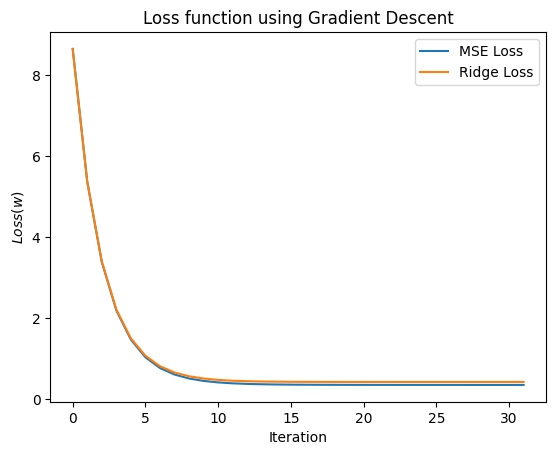

In [9]:
# Parameters
Lambda = 0.01
Eta = 0.1
Tolerance = 1e-6

# Perform gradient descent
w_predicted, mse_loss_history, ridge_loss_history = gradient_descent_ridge(X_train, y_train, initial_w, Eta, Lambda, Tolerance)
print("The regularized weights using ridge regression:\n", w_predicted)

# Plot loss history
plt.plot(mse_loss_history, label = 'MSE Loss')
plt.plot(ridge_loss_history, label = 'Ridge Loss')
plt.xlabel("Iteration")
plt.ylabel("$Loss(w)$")
plt.title("Loss function using Gradient Descent")
plt.legend()
plt.show()

## 1A.3 Test module (5pts)

We still need a method to evaluate the model constructed. Here, we plot the predicted values on the test data, together with the training points.

Let's take a look at the final results.


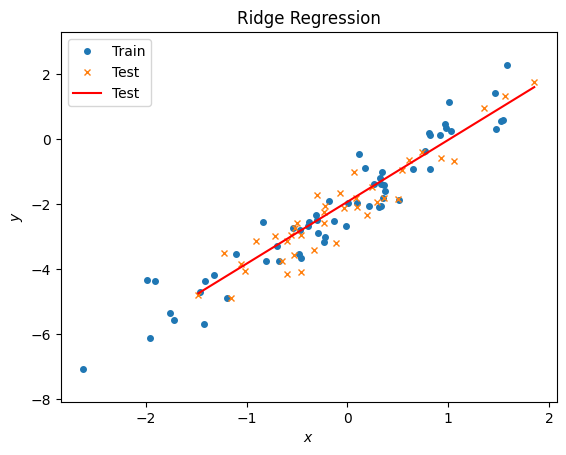

In [10]:
# Plot predicted function
fig = plt.subplot(111)

y_max = max(np.max(y_train), np.max(y_test))
y_min = min(np.min(y_train), np.min(y_test))
x_max = max(np.max(X_train[:, 1]), np.max(X_test[:,  1]))
x_min = min(np.min(X_train[:, 1]), np.min(X_test[:,  1]))
train_plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Ridge Regression', 'legend': True,
                 'y_lim': [y_min - 1, y_max + 1],
                 'x_lim': [x_min - 1, x_max + 1],
                 'marker': 'o', 'size': 4, 'label': 'Train'
                 }
test_plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Ridge Regression', 'legend': True,
                 'y_lim': [y_min - 1, y_max + 1],
                 'x_lim': [x_min - 1, x_max + 1],
                 'marker': 'x', 'size': 4, 'label': 'Test'
                 }

plot_data(X_train[:,1], y_train, fig=fig, options=train_plot_opts)
plot_data(X_test[:,1], y_test, fig=fig, options=test_plot_opts)
plot_fit(X_test, w_predicted, fig=fig, options=test_plot_opts)


## 1A.4 Expected Error (True Risk) (Bonus 10pts)

In this section we have a brief overview of the estimation of the model's expected error, and some factors related to the model consistency.

### 1A.4.1 Estimation of Expected Error for Linear Regressor (6pts)

**Direct Estimation (Students' Task):**

The true risk for our linear regression model can be directly computed since we know:
- Input x is sampled from standard normal distribution: $x \sim \mathcal{N}(0,1)$
- True parameter is $w_{true} = [2, -2]^T$
- Noise follows $\epsilon \sim \mathcal{N}(0, \sigma^2)$ where $\sigma = 0.6$

For a learned parameter $\theta$, the true error given MSE as the loss function is:

$E_{gen}(\theta) = \mathbb{E}_x[(w_{true}^T x + \epsilon - \theta^T x)^2]$

$= \mathbb{E}_x[(w_{true}^T x - \theta^T x)^2] + \mathbb{E}[\epsilon^2]$

$= (w_{true} - \theta)^T \mathbb{E}[xx^T](w_{true} - \theta) + \sigma^2$

$= (w_{true} - \theta)^T I(w_{true} - \theta) + \sigma^2$

$= \|w_{true} - \theta\|_2^2 + \sigma^2$

where we used:
- $\mathbb{E}[xx^T] = I$ for standard normal distribution
- $\mathbb{E}[\epsilon^2] = \sigma^2$
- Independence of x and $\epsilon$

**K-fold Cross-validation:**

We can compare this theoretical expected error with estimates from k-fold cross-validation:

$\hat{E}_{gen}(\theta) = \frac{1}{k} \sum_{i=1}^k [ \frac{1}{|V_i|} \sum_{(x,y)\in V_i} (y - \theta_i^T x)^2 ]$

where:
- k is the number of folds
- $V_i$ is the validation set (i-th fold)
- $\theta_i$ is the model trained on all folds except $V_i$
- $|V_i|$ is the size of the validation fold

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Students Code for this Function
def true_gen_error(theta: np.array, w_true: np.array = np.array([-2, 2]), sigma: float = 0.6) -> float:
    """
    Calculate true generalization error.
    
    Args:
        theta (np.array): Learned polynomial coefficients
        w_true (np.array): True polynomial coefficients
        sigma (float): Standard deviation of Gaussian noise
    
    Returns:
        float: True generalization error
    """
    error = 0
    # ! YOUR CODE STARTS HERE
    error = np.sum((w_true - theta)**2) + sigma**2
    
    # ! YOUR CODE ENDS HERE
    return error

# In this section we directly call CV from sklearn
def estimate_gen_error_cv(X: np.array, y: np.array, k: int = 5) -> Tuple[float, float]:
    """
    Estimate generalization error using k-fold cross-validation.
    
    Args:
        X (np.array): Feature matrix
        y (np.array): Target values
        k (int): Number of folds for cross-validation
    
    Returns:
        Tuple[float, float]: Mean and standard deviation of the estimated generalization error
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    errors = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train model
        initial_theta = np.zeros((X_train.shape[1], ))
        theta, _, _ = gradient_descent_ridge(X_train, y_train, initial_theta, 0.01, 0.1, 1e-6)
        
        # Calculate MSE on validation set
        y_pred = X_val.dot(theta)
        mse = mean_squared_error(y_val, y_pred)
        errors.append(mse)
    
    return np.mean(errors), np.std(errors)

# Compare theoretical and estimated errors
theta_learned, _, _ = gradient_descent_ridge(X_train, y_train, np.zeros((2, )), 0.01, 0.1, 1e-6)
true_error = true_gen_error(theta_learned)
cv_error, cv_std = estimate_gen_error_cv(X_train, y_train)

print(f"True generalization error: {true_error:.4f}")
print(f"5-fold CV estimate: {cv_error:.4f} (±{cv_std:.4f})")

True generalization error: 0.4661
5-fold CV estimate: 0.4387 (±0.1543)


### 1A.4.2 Expected Error Convergence Rate (4pts)

As discussed by Vladimir Vapnik in his foundation laying work *The Nature of Statistical Learning Theory* (Springer, 1995), learning theory must address four principal questions:

1. What are the (necessary and sufficient) conditions for consistency of a learning process based on the Empirical Risk Minimization (ERM) principle?  
2. **How fast is the rate of convergence of the learning process?**  
3. How can one control the rate of convergence (the generalization ability) of the learning process?
4. How can one construct algorithms that can control the generalization ability?

When we focus on the second question—namely, the rate of convergence of the learning process—and how various factors affect the **expected error**. Key considerations include:

- **Distribution mismatch**: Differences between the training data generation distribution and the “true” (or test) distribution, often quantified through divergences such as KL divergence.  
- **Number of training samples**: Larger datasets typically lead to faster convergence rates under mild assumptions about the data-generating process.  
- **Model complexity**: More complex hypothesis classes may require stronger regularization or more data to achieve comparable convergence.  
- **Observation noise**: Higher noise levels can slow convergence by obscuring the true signal and increasing variance in parameter estimates.

In what follows, we briefly highlight the role of observation noise in shaping the convergence rate of the expected error in empirical study. We will see that increasing noise typically inflates error bounds and slows down the overall convergence, further underscoring the importance of careful model selection and noise-robust learning algorithms.

**Your task**: Implement `fit_naive_linear_regression` and answer questions at the placeholder markers (`YOUR ANSWER HERE`). 

In [ ]:
def analyze_noise_impact(noise_levels: list = [0.9, 1.2, 1.5, 1.8, 2.1, 2.4], 
                         sample_sizes: np.array = np.linspace(10, 40, 6, dtype=int),
                         w_true: np.array = np.array([-2, 2]),
                         n_repeats: int = 10) -> None:
    """
    Analyze impact of observation noise on expected error convergence.
    
    Args:
        noise_levels (list): Different noise levels to test
        sample_sizes (np.array): Different sample sizes to test
        w_true (np.array): True polynomial coefficients
        n_repeats (int): Number of repetitions for each configuration
    """
    # Store results
    true_errors = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}
    cv_errors = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}
    cv_stds = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}

    # Store results for naive linear regression
    naive_true_errors = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}
    naive_cv_errors = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}
    naive_cv_stds = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}
    
    def fit_naive_linear_regression(X: np.array, y: np.array) -> np.array:
        """Fit linear regression using normal equations"""
        w = np.zeros((X.shape[1], ))
        # ! YOUR CODE STARTS HERE
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        # ! YOUR CODE ENDS HERE
        return w
    
    def estimate_naive_gen_error_cv(X: np.array, y: np.array, k: int = 5) -> Tuple[float, float]:
        """Estimate expected error for naive linear regression using k-fold CV"""
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        errors = []
        
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            theta = fit_naive_linear_regression(X_train, y_train)
            y_pred = X_val @ theta
            mse = mean_squared_error(y_val, y_pred)
            errors.append(mse)
        
        return np.mean(errors), np.std(errors)
    
    # Run experiments
    for noise in noise_levels:
        print(f"Processing noise level: {noise}")
        for i, n_samples in enumerate(sample_sizes):
            for j in range(n_repeats):
                # Generate data
                X_train, X_test, y_train, y_test = generate_and_plot_data(
                    n_samples, noise, w_true, test_size=0.2)
                
                # Train model
                theta_init = np.zeros((X_train.shape[1], ))
                theta_learned, _, _ = gradient_descent_ridge(X_train, y_train, theta_init, 0.001, 0.1, 1e-6)
                
                # Calculate true expected error
                true_errors[noise][i, j] = true_gen_error(theta_learned, w_true, noise)
                
                # Estimate expected error using cross-validation
                cv_error, cv_std = estimate_gen_error_cv(X_train, y_train)
                cv_errors[noise][i, j] = cv_error
                cv_stds[noise][i, j] = cv_std

                # Naive linear regression
                theta_naive = fit_naive_linear_regression(X_train, y_train)
                naive_true_errors[noise][i, j] = true_gen_error(theta_naive, w_true, noise)
                naive_cv_error, naive_cv_std = estimate_naive_gen_error_cv(X_train, y_train)
                naive_cv_errors[noise][i, j] = naive_cv_error
                naive_cv_stds[noise][i, j] = naive_cv_std
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot true expected error for ridge regression
    plt.subplot(231)
    for noise in noise_levels:
        mean_error = np.mean(true_errors[noise], axis=1)
        std_error = np.std(true_errors[noise], axis=1)
        
        plt.plot(sample_sizes, mean_error, label=f'σ={noise}', marker='o')
        plt.fill_between(sample_sizes, mean_error - std_error, mean_error + std_error, alpha=0.2)
    
    plt.xlabel('Number of Training Samples')
    plt.ylabel('True Expected Error')
    plt.title('Ridge Regression: True Expected Error')
    plt.legend()
    plt.grid(True)
    
    # Plot CV estimated error for ridge regression
    plt.subplot(232)
    for noise in noise_levels:
        mean_error = np.mean(cv_errors[noise], axis=1)
        mean_std = np.mean(cv_stds[noise], axis=1)
        
        plt.plot(sample_sizes, mean_error, label=f'σ={noise}', marker='o')
        plt.fill_between(sample_sizes, mean_error - mean_std, mean_error + mean_std, alpha=0.2)
    
    plt.xlabel('Number of Training Samples')
    plt.ylabel('CV Estimated Error')
    plt.title('Ridge Regression: CV Est. Error')
    plt.legend()
    plt.grid(True)

    # Plot ratio of true/CV error for ridge regression
    plt.subplot(233)
    for noise in noise_levels:
        mean_true = np.mean(true_errors[noise], axis=1)
        mean_cv = np.mean(cv_errors[noise], axis=1)
        ratio = mean_true / mean_cv
        
        plt.plot(sample_sizes, ratio, label=f'σ={noise}', marker='o')
    
    plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Number of Training Samples')
    plt.ylabel('True/CV Error Ratio')
    plt.title('Ridge Regression: Error Ratio')
    plt.legend()
    plt.grid(True)

    # Plot true expected error for naive regression
    plt.subplot(234)
    for noise in noise_levels:
        mean_error = np.mean(naive_true_errors[noise], axis=1)
        std_error = np.std(naive_true_errors[noise], axis=1)
        
        plt.plot(sample_sizes, mean_error, label=f'σ={noise}', marker='o')
        plt.fill_between(sample_sizes, mean_error - std_error, mean_error + std_error, alpha=0.2)
    
    plt.xlabel('Number of Training Samples')
    plt.ylabel('True Expected Error')
    plt.title('Naive Regression: True Expected Error')
    plt.legend()
    plt.grid(True)

    # Plot CV estimated error for naive regression
    plt.subplot(235)
    for noise in noise_levels:
        mean_error = np.mean(naive_cv_errors[noise], axis=1)
        mean_std = np.mean(naive_cv_stds[noise], axis=1)
        
        plt.plot(sample_sizes, mean_error, label=f'σ={noise}', marker='o')
        plt.fill_between(sample_sizes, mean_error - mean_std, mean_error + mean_std, alpha=0.2)
    
    plt.xlabel('Number of Training Samples')
    plt.ylabel('CV Estimated Error')
    plt.title('Naive Regression: CV Est. Error')
    plt.legend()
    plt.grid(True)
    
    # Plot ratio of true/CV error for naive regression
    plt.subplot(236)
    for noise in noise_levels:
        mean_true = np.mean(naive_true_errors[noise], axis=1)
        mean_cv = np.mean(naive_cv_errors[noise], axis=1)
        ratio = mean_true / mean_cv
        
        plt.plot(sample_sizes, ratio, label=f'σ={noise}', marker='o')
    
    plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Number of Training Samples')
    plt.ylabel('True/CV Error Ratio')
    plt.title('Naive Regression: Error Ratio')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_noise_impact()

Processing noise level: 0.9
Processing noise level: 1.2
Processing noise level: 1.5
Processing noise level: 1.8
Processing noise level: 2.1
Processing noise level: 2.4


#### Questions
- How does observation noise affect generalization performance? Please discuss your findings here. (2 pts)
- `YOUR ANSWER HERE`

# Task 1B: Real Dataset: House Value Prediction (50 points)

We will use the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from the scikit-learn package. The task is to predict the house values in California districts given some summary stats about them based on the 1990 census data.

The dataset has 8 features: longitudes, latitudes, housing median age, total rooms, total bedrooms, population, households, median income, and median house value. The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($\$100,000$). We split the dataset as 80\% for training data and 20\% for testing data. 

The script below fetches the California housing dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

california = fetch_california_housing()
california_df = pd.DataFrame(california.data, columns=california.feature_names)
california_df['Price'] = california.target

newX = np.array(california_df.drop('Price', axis=1))
newY = np.array(california_df['Price'])

newX = StandardScaler().fit_transform(newX)

print(f'Shape of newX: {newX.shape}, shape of newY: {newY.shape}')

Shape of newX: (20640, 8), shape of newY: (20640,)


## 1B.1. Regularization and generalization

In this subsection, we will aim to analyze the link between regularization and generalization. In particular, the question we aim to address is: "Does more regularization benefit generalization?"

In our context, this means answering "does a higher value of $\lambda$ allow us to achieve a lower test MSE?"


Following the script below, you will be able to first generate the training and test data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(newX, newY, test_size = 0.2, random_state = 42)

print(f'{X_train.shape=}, {X_test.shape=}, {y_train.shape=}, {y_test.shape=}')

X_train.shape=(16512, 8), X_test.shape=(4128, 8), y_train.shape=(16512,), y_test.shape=(4128,)


### $\lambda$ comparison implementation (10pts)
Write a function to fit the Ridge regression via gradient descent on the training data, and calculate the final MSE loss and test MSE loss for a particular choice of $\lambda$.


❗**Note**: You should write your own model fitting and prediction (following the ones you construct in Task 1A). You may call your customized function `ridge_loss_function` and `gradient_descent_ridge` from 1A.1 and 1A.2. Do not use `sklearn.linear_model` module (i.e. for model fitting and making predictions).

In [ ]:
def train_and_eval_lambda(X_train, y_train, X_eval, y_eval, Lambda, eta = 0.003, tolerance = 1e-8, num_iter = int(1e6)):
    """
        This function trains ridge regression on the training set, and evaluate on the eval set.
        
        Returns final_train_mse: the MSE of the predicted weight on the train set, and test_mse: the MSE of the predicted weight on the eval set
    """
    # Initialize w at 0
    initial_w = np.zeros(X_train.shape[1])

    # ! YOUR CODE STARTS HERE
    w_predicted, _, _ = gradient_descent_ridge(X_train, y_train, initial_w, eta, Lambda, tolerance, num_iter)
    final_train_mse = mean_squared_error(y_train, X_train @ w_predicted)
    test_mse = mean_squared_error(y_eval, X_eval @ w_predicted)

    # ! YOUR CODE ENDS HERE
    
    
    return final_train_mse, test_mse

Below, use the function above to compare which value of $\lambda$ among `LAMBDA_LIST = [1e-8, 1e-6, 1e-4, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]` achieves the best test error.

Best lambda is 0.03


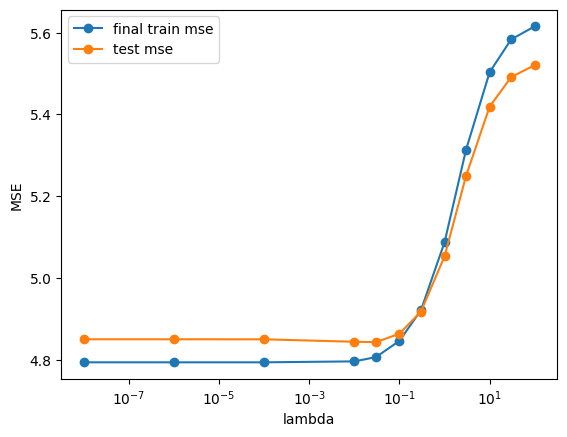

In [ ]:
LAMBDA_LIST = [1e-8, 1e-6, 1e-4, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
test_mse_list = []
final_train_mse_list = []

best_lambda = None
best_test_mse = np.inf
for Lambda in LAMBDA_LIST:
    final_train_mse, test_mse = train_and_eval_lambda(X_train, y_train, X_test, y_test, Lambda)
    test_mse_list.append(test_mse)
    final_train_mse_list.append(final_train_mse)
    
    if test_mse < best_test_mse:
        best_test_mse = test_mse
        best_lambda = Lambda
    # ! YOUR CODE ENDS HERE


print(f'Best lambda is {best_lambda}')
plt.figure()
plt.plot(LAMBDA_LIST, final_train_mse_list, label = 'final train mse', marker = 'o')
plt.plot(LAMBDA_LIST, test_mse_list, label = 'test mse', marker = 'o')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.xscale('log')
plt.legend()
plt.show()

### Analysis of experimental results (10pts)
1. Describe the general trend of the final train MSE, as well as the test MSE, as $\lambda$ increases.
- `YOUR ANSWER HERE`
2. From the cell above, conclude which choice of $\lambda$ gives rise to the best weights, as indicated by the test MSE. In theory, what does regularization offer towards generalization, and through what mechanism?
- `YOUR ANSWER HERE`

3. In practice (as in the experiment above), do you see what is expected here? Explain why/why not, and explain why that might be so for this particular dataset.
- `YOUR ANSWER HERE`


## 1B.2. Model selection via k-fold cross validation

In the above, we were simply visualizing the effect of $\lambda$ on the test MSE. However, in the real world, we obviously do not have access to `y_test`, and hence it is not obvious a priori what choice of $\lambda$ would give rise to the "best" model in the real world. 

This process of choosing the "right" $\lambda$ is done via model selection. In this subsection, we'll do that via *$k$-fold cross validation* on the training set. In the function below, implement $k$-fold cross validation.

❗**Note:** For this subproblem, you should write your own function for cross validation; in particular, you should **not** call the existing `sklearn.model_selection` module.

### Implementation: K-fold cross validation  (5pts)

In [ ]:
def cross_validation_lambda(X_train, y_train, Lambda, k=10):
    """
    Perform k-fold cross validation on X_train and y_train, return the average over folds of the mean square error on the test portion of (X_train, y_train)
    
    Returns the mean MSE loss over folds of validation set.
    """
    mse_list = []

    # ! YOUR CODE STARTS HERE
    n = X_train.shape[0]
    indices = np.arange(n)
    folds = np.array_split(indices, k)

    for i in range(k):

        val_indices = folds[i]
        train_indices = []
        for j in range(k):
            if j != i:
                train_indices.extend(folds[j])

        X_tr, X_val = X_train[train_indices], X_train[val_indices]
        y_tr, y_val = y_train[train_indices], y_train[val_indices]

        initial_w = np.zeros(X_tr.shape[1])

        w_pred, _, _ = gradient_descent_ridge(X_tr, y_tr, initial_w, eta = 0.01, tolerance = 1e-6, Lambda=Lambda)

        test_mse = mean_squared_error(y_val, X_val @ w_pred)

        mse_list.append(test_mse)
    # ! YOUR CODE ENDS HERE

    return np.mean(mse_list)

### Implementation: $\lambda$ selection via cross validation  (5pts)

Use the cross validation function above to choose the best $\lambda$, based on the cross validation MSE loss.

Best lambda:  1e-06


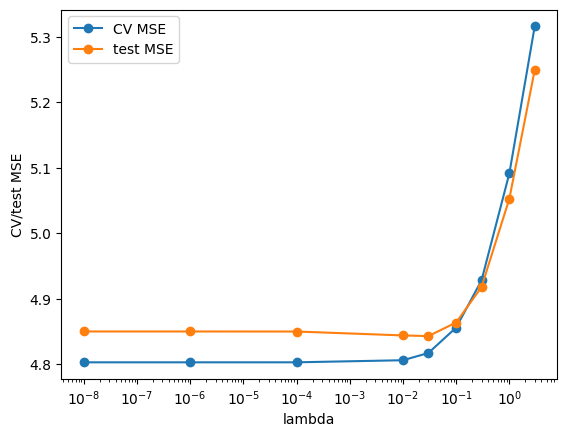

In [ ]:
best_lambda = None
best_mse = np.inf

# Find the best lambda
cv_mse_list = []
for Lambda in LAMBDA_LIST[:-3]:
    # ! YOUR CODE STARTS HERE
    cv_mse = cross_validation_lambda(X_train, y_train, Lambda, k=10)
    cv_mse_list.append(cv_mse)

    if cv_mse < best_mse:
        best_mse = cv_mse
        best_lambda = Lambda
    # ! YOUR CODE ENDS HERE

print("Best lambda: ", best_lambda)

plt.figure()
plt.plot(LAMBDA_LIST[:-3], cv_mse_list, label = 'CV MSE', marker = 'o')
plt.plot(LAMBDA_LIST[:-3], test_mse_list[:-3], label = 'test MSE', marker = 'o')
plt.xlabel('lambda')
plt.ylabel('CV/test MSE')
plt.xscale('log')
plt.legend()
plt.show()

### Analysis of experimental results (10pts)
1. Suppose that we want to reserve the test set (X_test, y_test) for final evaluation purpose. In particular, it cannot be used in our model selection process. In this case, given that we only see the training set during model selection, what is the naive approach that the experimental pipeline as set up in 1B.1 can offer us to do model selection?
- `YOUR ANSWER HERE`
2. Compare 10-fold cross validation against the different setting where we do a train-validation-test split, and the chosen lambda is the lambda with the least loss on the validation set (after training on the train set). Why might the 10-fold cross validation be more robust than this single-validation approach? It might help to mention a particular situation where the single-validation approach can be misled.
- `YOUR ANSWER HERE`

## 1B.3. Polynomial model selection

In this question, you will perform polynomial regression via gradient descent on a subset of the California housing dataset as imported above, and use cross-validation to determine the optimal degree of polynomial. For simplicity, we will use the first feature of the dataset and study its relationship with housing prices.


The polynomial regression of degree $D$ aims to minimize the (unregularized) MSE loss$$ R({\mathbf{w}}) = \mathbb{E}[(y-\sum_{d = 1}^{D}w_d x^d)^2)] = \mathbb{E}[(y-{\mathbf{w}}^\top \tilde{x})^2)],$$ where $x$ is our singular feature, and $\tilde{x} = [1, x, ..., x^d]$.

In particular, this reverts to simple linear regression when $d = 1$. The risk is approximated by the *empirical risk* as: $$\hat{R}_{\text{MSE}}(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n \left(y_i - \sum_{d = 1}^{D}w_d x_i^d\right)^2.$$

Your task is to repeat Task 1B.2. with cross-validation, but now over the degree of polynomial to choose the "best" degree of polynomial for our prediction task.

❗**Note**: You should write your own model fitting and prediction (following the ones you construct in Task 1A). You may only call your customized functions. Do not use `sklearn.linear_model` module (i.e. for model fitting and making predictions).

Hint: You can reuse some functions from previous tasks by setting $\lambda$ to an appropriate value. Also feel free to write new functions.

The script below takes a subset of the California data, at the first coordinate.

In [ ]:
# load data
i= 1
num_data = 2000
X = newX[i*num_data:(i+1)*num_data, 0].reshape(-1, 1)
y = np.array(newY[i*num_data:(i+1)*num_data])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print(f'{X_train.shape = }, {y_train.shape=}')

X_train.shape = (1600, 1), y_train.shape=(1600,)


### Implementation: train and eval by degree (2pts)

In the function below, you should write a similar `train_and_eval` as above. However, note that `X_train` as fed in, will only consist of 1 feature. It is your responsibility to transform this into polynomial features, and run gradient descent.

In [ ]:
def train_and_eval_degree(X_train, y_train, X_eval, y_eval, degree, eta = 0.003, tolerance = 1e-8, num_iter = 1e6):
    """
        This function transforms the data to the appropriate degree, and trains on the training set via simple linear regression gradient descent, and evaluates on the eval set.
        
        Returns final_train_mse and test_mse.
    """
    # ! YOUR CODE STARTS HERE
    X_train_poly = np.ones((X_train.shape[0], degree))
    X_eval_poly = np.ones((X_eval.shape[0], degree))

    for p in range(degree):
        X_train_poly[:, p] = X_train[:, 0] ** (p+1)
        X_eval_poly[:, p] = X_eval[:, 0] ** (p+1)
    

    initial_w = np.zeros(X_train_poly.shape[1])

    w_predicted, _, _ = gradient_descent_ridge(X_train_poly, y_train, initial_w, eta, 0.0, tolerance, num_iter)

    final_train_mse = mean_squared_error(y_train, X_train_poly @w_predicted)
    test_mse = mean_squared_error(y_eval, X_eval_poly @ w_predicted)
    
    # ! YOUR CODE ENDS HERE
    return final_train_mse, test_mse

### Implementation: cross validation by degree (3pts)

Similarly, implement cross validation, now for each degree.

In [ ]:
def cross_validation_degree(X_train, y_train, degree, k=10):
    """
    Perform k-fold cross validation on X_train and y_train, return the mean square error on the test portion of (X_train, y_train) across the k folds
    """
    mse_list = []

    # ! YOUR CODE STARTS HERE
    X_train_poly = np.ones((X_train.shape[0], degree))

    for p in range(degree):
        X_train_poly[:, p] = X_train[:, 0] ** (p+1)

    n = X_train_poly.shape[0]
    indices = np.arange(n)
    folds = np.array_split(indices, k)

    for i in range(k):

        val_indices = folds[i]
        train_indices = []
        for j in range(k):
            if j != i:
                train_indices.extend(folds[j])

        X_tr, X_test = X_train_poly[train_indices], X_train_poly[val_indices]
        y_tr, y_test = y_train[train_indices], y_train[val_indices]

        initial_w = np.zeros(X_tr.shape[1])

        w_predicted, _, _ = gradient_descent_ridge(X_tr, y_tr, initial_w, 0.003, 0.0, 1e-8, 1e6)

        test_mse = mean_squared_error(y_test, X_test @ w_predicted)

        mse_list.append(test_mse)
    # ! YOUR CODE ENDS HERE

    return np.mean(mse_list)


You shouldn't need to modify the script below. It plots and selects the best degree, based on cross validation.

cross validation with degree:  1
cross validation with degree:  2
cross validation with degree:  3
cross validation with degree:  4
Best degree:  4


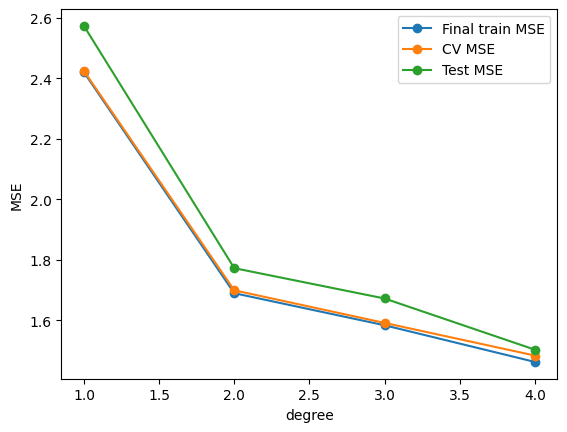

In [ ]:
DEGREE_LIST = np.array([1, 2, 3, 4])
best_degree = None
best_mse = np.inf

# Find the best lambda
cv_mse_list = []
test_mse_list = []
final_train_mse_list = []
for degree in DEGREE_LIST:
    print("cross validation with degree: ", degree)
    cv_mse = cross_validation_degree(X_train, y_train, degree)
    final_train_mse, test_mse = train_and_eval_degree(X_train, y_train, X_test, y_test, degree)
    final_train_mse_list.append(final_train_mse)
    test_mse_list.append(test_mse)
    cv_mse_list.append(cv_mse)
    if cv_mse < best_mse:
        best_mse = cv_mse
        best_degree = degree

print("Best degree: ", best_degree)

plt.figure()
plt.plot(DEGREE_LIST, final_train_mse_list, label = 'Final train MSE', marker = 'o')
plt.plot(DEGREE_LIST, cv_mse_list, label = 'CV MSE', marker = 'o')
plt.plot(DEGREE_LIST, test_mse_list, label = 'Test MSE', marker = 'o')
plt.xlabel('degree')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Analysis of Experimental Results (5pts)
1. Based on experimental results, what is your conclusion about what the best degree is using the CV method? Does this align with the degree that achieved the best test error?
- `YOUR ANSWER HERE`

2. Interpret the experimental results above. Does the plot above match your expectations about what increasing the polynomial degree might mean? Explain the trend of the train MSE. 
- `YOUR ANSWER HERE`

3. Note that the lower $y$-limit is not 0, which means that the graph above is quite zoomed in. What can you say about the dataset, the degree of the features that are actually relevant, and conclude whether the alignment/non-alignment in Question 1 is an issue.
- `YOUR ANSWER HERE`

# [Bonus] 1C. Implementing LASSO Regression (10 points)

In the previous tasks, you implemented **Ridge regression**, which uses L2 regularization ($\lambda ||\mathbf{w}||_2^2 = \lambda \mathbf{w}^\top \mathbf{w}$) to prevent overfitting by penalizing large weights. In this bonus question, you will explore **LASSO (Least Absolute Shrinkage and Selection Operator) regression**, another regularization technique that uses L1 regularization ($\lambda ||\mathbf{w}||_1$) instead. 

While both Ridge and LASSO add a penalty term to the loss function, they have important differences: Ridge regression tends to shrink all weights proportionally, while LASSO can drive some weights exactly to zero, effectively performing **feature selection** by removing less important features from the model. This sparsity property makes LASSO particularly useful when dealing with high-dimensional data where many features may be irrelevant. 

We still consider the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html).


**Note**: While LASSO regression will be covered in detail in a future lecture, this bonus question gives you the opportunity to implement it yourself and observe its behavior. You can leverage your experience with Ridge regression, as the implementation follows a similar structure but with a different penalty term.

Following the previous notation, we consider the Lasso regression risk function, defined as 
$$ R({\mathbf{w}}) = \mathbb{E}[(y-{\mathbf{w}}^\top x)^2)] +  \lambda ||\mathbf{w}||_1$$

where the expectation is taken over the data generating the distribution of points. As the whole data generating distribution is not known, the expectation is approximated by samples from the **training** set. 

The risk is approximated by the *empirical risk* as:

$$\hat{R}_{\text{lasso}}(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n \left(y_i - \mathbf{w}^\top \mathbf{x}_i\right)^2 + \lambda ||\mathbf{w}||_1$$

In the following, construct a customized function which returns the empirical risk and its gradient at parameter $\theta$.


In [ ]:
# Constructing the empirical risk function for LASSO regression.
def lossFunctionLASSO(theta, X, y, Lambda):
    """
    Take in numpy array of theta, X, and y to return the regularize loss function and gradient
    of a LASSO regression
    """
    # initialize regularized average loss (empirical risk) and its gradient
    regLoss = 0
    grad = np.zeros(theta.shape)

    # add your code to compute the LASSO regression risk function and its gradient #
    # 
     
    return regLoss, grad
def gradientDescent(X,y,theta,eta,Lambda,tolerance,max_iter=1000):
    # you can reuse your code from ridge regression and modify it accordingly #
    return theta, Loss_history

def train_and_eval( X_train , y_train , X_eval , y_eval , lambda_ ):
    # you can reuse your code from ridge regression and modify it accordingly #
    return mse
    
LAMBDA_LIST = [1e-8, 1e-6, 1e-4, 0.01, 0.1, 1, 10, 100]
result_list = []

# compute test MSE
for Lambda in LAMBDA_LIST:
    test_mse = train_and_eval (X_train , y_train , X_test , y_test , Lambda)
    result_list.append ([ test_mse , Lambda ])
    result_array = np.array ( result_list )

plt.figure()
plt.plot( result_array [: , -1] , result_array [: ,0] , label = 'test mse')
plt.xlabel('lambda')
plt.ylabel('test mse')
plt.yscale('log')
plt.legend()
plt.show()

### Analysis of LASSO Regression Results (4pts)
1. Based on your experimental results, what is the optimal choice of $\lambda$ for this dataset? Compare this with your findings from Ridge regression in Task 1B.2. What are the key differences between the two regularization methods in terms of their behavior and the resulting models?
- `YOUR ANSWER HERE`